In [1]:
import torch
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

/home/kobayashi/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.15.layer_norm1.bias', 'vision_model.encoder.layers.9.self_attn.out_proj.weight', 'vision_model.encoder.layers.17.self_attn.q_proj.bias', 'vision_model.encoder.layers.10.self_attn.k_proj.bias', 'vision_model.encoder.layers.19.self_attn.q_proj.bias', 'vision_model.encoder.layers.20.self_attn.out_proj.bias', 'vision_model.encoder.layers.12.layer_norm2.bias', 'vision_model.encoder.layers.17.self_attn.out_proj.bias', 'vision_model.encoder.layers.20.layer_norm1.bias', 'vision_model.encoder.layers.17.self_attn.v_proj.bias', 'vision_model.encoder.layers.

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [3]:
from diffusers import LMSDiscreteScheduler

scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

In [4]:
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

In [57]:
# promptを変更するたびにこの行から順に実行
# promptを混ぜ合わせるとき
# prompt1 = ["an anime of a sea　beach"]
# prompt2 = ["an anime of a sea　beach"]
# prompt1 = ["a photograph of a sea beach created by Makoto Shinkai"]
prompt2 = ["an illustration of a sea beach"]
prompt1 = ["a photograph of a sea beach"]
# prompt2 = ["a photograph of a sea beach created by Leonardo DaVinci"]

height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion

num_inference_steps = 100            # Number of denoising steps

guidance_scale = 7.5                # Scale for classifier-free guidance

generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise

batch_size = 1

###################################
text_input1 = tokenizer(prompt1, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input2 = tokenizer(prompt2, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")


with torch.no_grad():
  text_embeddings = text_encoder(text_input1.input_ids.to(torch_device))[0]

with torch.no_grad():
  text_embeddings2 = text_encoder(text_input2.input_ids.to(torch_device))[0]
#######################################
#２つのtextを混ぜる
# 足して2で割る
# for i in range(len(text_embeddings[0])):#77*768
#     for j in range(len(text_embeddings[0][i])):
#         text_embeddings[0][i][j] = int((text_embeddings[0][i][j]+text_embeddings2[0][i][j])/2)

# 半々
# for i in range(len(text_embeddings[0])):#77*768
#     for j in range(len(text_embeddings[0][i])):
#         if (i+j)%2==0:
#             text_embeddings[0][i][j] = text_embeddings2[0][i][j]
            
# max_length = text_input1.input_ids.shape[-1]

#　途中で足す
for i in range(int(len(text_embeddings[0])/2),len(text_embeddings[0])):
    text_embeddings[0][i] = text_embeddings2[0][i]

In [29]:
# promptを変更するたびにこの行から順に実行
# promptをないとき
#promptを混ぜるなら実行禁止
prompt = ["a photograph of a rabbit eating a leaf in front of a Christmas tree"]


height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion

num_inference_steps = 100            # Number of denoising steps

guidance_scale = 7.5                # Scale for classifier-free guidance

generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise

batch_size = 1

###################################
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")


with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

max_length = text_input.input_ids.shape[-1]

In [58]:

uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

In [59]:
embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [60]:
latents_torch = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents_torch.to(torch_device)

In [61]:
latents.shape

torch.Size([1, 4, 64, 64])

In [62]:
scheduler.set_timesteps(num_inference_steps)

In [63]:
latents_1 = latents * scheduler.init_noise_sigma

In [64]:
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image

for t in tqdm(scheduler.timesteps):
  # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
  latent_model_input_a = torch.cat([latents_1] * 2)

  latent_model_input = scheduler.scale_model_input(latent_model_input_a, t)

  # predict the noise residual
  with torch.no_grad():
    noise_pred = unet(latent_model_input, t, encoder_hidden_states=embeddings).sample

  # perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # compute the previous noisy sample x_t -> x_t-1
  latents_1 = scheduler.step(noise_pred, t, latents_1).prev_sample


100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


In [65]:
# scale and decode the image latents with vae
latents_3 = 1 / 0.18215 * latents_1

with torch.no_grad():
  image = vae.decode(latents_3).sample

In [66]:
image_1 = (image / 2 + 0.5).clamp(0, 1)
image_2 = image_1.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image_2 * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
result_image = pil_images[0]
result_image.save("sample.png")

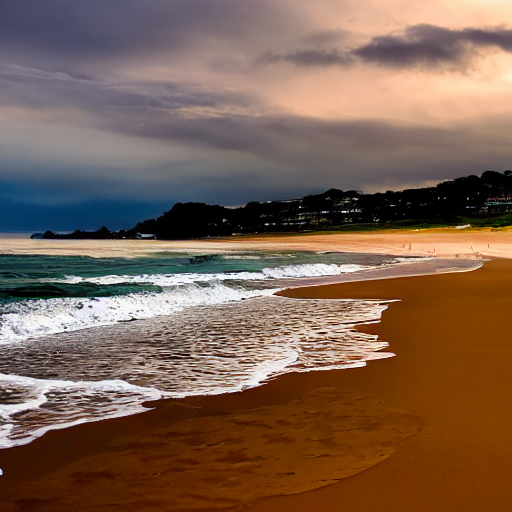

In [67]:
result_image

3
4
